# Working with a corpus: Vowels

* This notebook illustrates how one would extract phonetic measurements from a larger corpus.
* We will use "dir_to_df" from the fileorg repository to make a list of files to process
* Compute some phonetic measurements, and compile them into a big dataframe
* One feature of the demonstration here is that the phonetic tagging files in this corpus are not TextGrids (this is true of many corpora that are out there).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phonlab as phon
from IPython.display import Audio
import seaborn as sns

# some new (to us) python libraries
import os                       # operating sytem functions
from pathlib import Path        # cross-platform file path references
from fileorganize import dir_to_df   # read a corpus into a dataframe

pd.set_option('future.no_silent_downcasting',True)  # set an option for pandas
sns.axes_style("darkgrid")  # set some themes for seaborn plots
sns.set_theme()

## a. Get a list of the wav files in the corpus

* the code here assumes that the corpus is in a folder under the current working directory
* if that isn't true you will need to give a fuller description of where to find the corpus
* dir_to_df() walks the directory tree into all subfolders under corpus_folder looking for wav files
* dir_to_df() also parses the filename and returns information encoded in the filename

In [2]:
folder = os.getcwd()
print(folder)  ## just so you know where we will be looking for the corpus

path_to_corpus = Path('./dimex')
path_to_results = Path('./temp')  # this notebook will create this directory if it doesn't already exist

corpus_list = dir_to_df(path_to_corpus,
               fnpat = r'(?P<subj>s\d\d\d)(?P<sentence>\d+)\.wav',
               addcols = ["dirname", "barename"])
corpus_list.head()

/Users/kjohnson/My Drive (keithjohnson@berkeley.edu)/LSA_25


,dirname,relpath,fname,barename,subj,sentence
0,dimex,.,s00801.wav,s00801,s008,01
1,dimex,.,s00802.wav,s00802,s008,02
2,dimex,.,s00803.wav,s00803,s008,03
3,dimex,.,s00804.wav,s00804,s008,04
4,dimex,.,s00805.wav,s00805,s008,05


## b. Compute formants and save

* ordinarily there will be a spreadsheet of information about each talker
* Here we will just construct a small data frame instead of reading in a talker info spreadsheet
* In addition to  demographics, we also include some analysis parameters for formant and pitch tracking

In [3]:
talkers = pd.DataFrame([["s008", "F", 6000, 10,2,[120,300]],
                        ["s019", "M", 5500, 12, 1, [60,220]],
                        ["s038", "F", 5500, 10, 2, [100,350]],
                        ["s050", "M", 5000, 12, 1, [50,200]],
                        ["s072", "F", 5500, 10, 2, [150,300]],
                        ["s090", "M", 5000, 12, 1, [80,240]]],
                       columns = ('subj','gender','ceiling', 'order','ifc_speaker','pitch_range'))
'''
    'ceiling':     a parameter used in Praat formant tracking
    'order':       for phonlab lpc formant tracking
    'ifc_speaker': for phonlab ifc formant tracking
    'pitch_range': for pitch tracking
'''

corpus_list = corpus_list.merge(talkers,on='subj', how='left') # add the talker information to the list
corpus_list.head()

,dirname,relpath,fname,barename,subj,sentence,gender,ceiling,order,ifc_speaker,pitch_range
0,dimex,.,s00801.wav,s00801,s008,01,F,6000,10,2,"[120, 300]"
1,dimex,.,s00802.wav,s00802,s008,02,F,6000,10,2,"[120, 300]"
2,dimex,.,s00803.wav,s00803,s008,03,F,6000,10,2,"[120, 300]"
3,dimex,.,s00804.wav,s00804,s008,04,F,6000,10,2,"[120, 300]"
4,dimex,.,s00805.wav,s00805,s008,05,F,6000,10,2,"[120, 300]"


## Here we implement a loop, which... 
* takes each row of the corpus list
* construct a new name for the results of formant analysis
* check to see if the results file already exists, or if we are planning to overwrite all of the old ones.
* loads the wav file
* tracks the formants in the file
* saves the formant tracking results in a csv file for later use


In [4]:
overwrite = False
for row in corpus_list.itertuples():
    wav_name = path_to_corpus / row.relpath / row.fname  # Full path to .wav file
    formant_name = f"{row.barename}_formants.csv"
    result_name = path_to_results / row.relpath / formant_name   # Full path to result
    if overwrite is True or not result_name.exists():
        x,fs = phon.loadsig(wav_name,chansel=[0])  # read in the audio
        fdf = phon.track_formants(x,fs, method='ifc',
                                  speaker = row.ifc_speaker,
                                  order=row.order, 
                                  f0_range = row.pitch_range,
                                 quiet=True)  # compute formant frequencies
            
        result_name.parent.mkdir(parents=True, exist_ok=True)  # Make sure parent dir exists
        
        # Save formant measurements as .csv
        fdf.to_csv(result_name, index=False)
        print(f'Wrote formant results to {result_name}')

## c. Read and process one file

* In this block we build a function to read the tagging files in Dimex
* We will use [pandas.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) to read the phonetic tags.
* Then we will elaborate the dataframe with additional information (like word position, stress, etc)
* and merge in the formant measurements
* This function "process_a_dimex_file()" can then be used to build a database of vowel formant frequencies

In [5]:

def add_stress_column(value):
    if value in ['i_7', 'e_7', 'a_7', 'o_7', 'u_7']:
        return 'stressed'
    elif value in ['i','e','a','o','u']:
        return 'unstressed'
    else:
        return None

def process_a_dimex_file(row):
    phontags = path_to_corpus / row.relpath / f"{row.barename}_phn.txt"  # first file on the list
    wordtags = path_to_corpus / row.relpath / f"{row.barename}_wrd.txt"

    # read the _phn.txt and _wrd.txt files
    phdf = pd.read_csv(phontags,sep=r'\s+',skiprows=2,names=['t1','t2','phone'])  # an analog to tg_to_df()
    phdf.t1 = phdf.t1/1000  # convert millisecond times to seconds
    phdf.t2 = phdf.t2/1000
    wddf = pd.read_csv(wordtags,sep=r'\s+',skiprows=2,names=['t1','t2','word'])
    wddf.t1 = wddf.t1/1000  # convert millisecond times to seconds
    wddf.t2 = wddf.t2/1000
    #print(phdf.head())

    ## ------------------ write the labels out to a textgrid ------------------------
    textgrid_name = path_to_results / row.relpath / f"{row.barename}.TextGrid"
    phon.df_to_tg([phdf,wddf],['phone','word'], outfile= textgrid_name) 
    ## ------------------------------------------------------------------------------

    # Now, let's put together a data frame for taking observations from the formants files
    phdf = phon.add_context(phdf,'phone',nprev=1,nnext=1)   # add phonetic context
    merged = phon.merge_tiers(phdf,wddf,suffixes=['','wd'])  # merge in the word tier

    # code each phonetic segment for word position
    merged['wordposition'] = 'medial'
    merged['wordposition'] = np.where(merged['t2'] == merged['t2wd'],"final",merged['wordposition'])
    merged['wordposition'] = np.where(merged['t1'] == merged['t1wd'],"initial",merged['wordposition'])

    # add some info from the corpus_list
    merged['speaker'] = row.subj 
    merged['gender'] = row.gender
    merged['sentence'] = row.sentence
    #print(merged.head())

    # add observation points for vowel measurements
    vowels = ['i_7', 'e_7', 'a_7', 'o_7', 'u_7', 'i', 'e', 'a', 'o', 'u']
    vowelsdf = merged.query(f'phone in {vowels}')  # make a dataframe that just has vowels
    vowelsdf = phon.explode_intervals([0.5], ts=['t1', 't2'], df=vowelsdf) # get times for observations

    # add vowel duration and stress information
    vowelsdf['vowel_dur'] = (vowelsdf['t2'] - vowelsdf['t1'])*1000  # add a vowel duration column
    vowelsdf['stress'] = vowelsdf['phone'].map(add_stress_column)  # use the pandas .map() function
    vowelsdf = vowelsdf.replace(to_replace = r'_7', value= r'', regex=True)  # take the '_7' off of the vowel symbols

    vowelsdf.drop(columns=['t1','t2','t1wd','t2wd'],inplace=True)  # drop the word onset/offset times
    #print(vowelsdf.head())

    # Now add the formant measurements to the dataframe 
    result_name = path_to_results / row.relpath / f"{row.barename}_formants.csv"
    fmtsdf = pd.read_csv(result_name)  # read in the csv of formants measurements

    vowelsdf = phon.interpolate_measures(
        meas_df=fmtsdf[['sec','f0','F1', 'F2', 'F3', 'F4']],  # time axis and cols to interpolate
        meas_ts='sec',        # time index in the measurements dataframe
        interp_df=vowelsdf,       # textgrid dataframe
        interp_ts='obs_t',  # target observation times in the textgrid
        overwrite=True
    )
    
    return vowelsdf

df = process_a_dimex_file(corpus_list.iloc[0])  # try out the function on the first file in the corpus
print(df.shape)
df.head()

(17, 17)


,prev_phone1,phone,next_phone1,word,wordposition,speaker,gender,sentence,obs_t,obs_id,vowel_dur,stress,f0,F1,F2,F3,F4
3,p,e,r(,pero,medial,s008,F,01,0.138035,0.5,64.839569,stressed,210.526000,429.170922,2112.726678,2846.237847,4257.017205
5,r(,o,n,pero,final,s008,F,01,0.261029,0.5,60.828873,unstressed,203.390000,601.411124,1457.448103,2981.330410,3849.139740
7,n,o,s,no,final,s008,F,01,0.412433,0.5,78.876984,unstressed,235.294000,613.856079,1448.446399,3114.089444,4094.484831
9,s,o,-R,solo,medial,s008,F,01,0.590575,0.5,63.502686,stressed,255.319000,656.223530,1699.031947,2904.999464,3932.399353
12,l,o,a,solo,final,s008,F,01,0.723262,0.5,53.475952,unstressed,238.464892,652.284638,1413.116517,2765.910091,3364.334840


## d.  Now process all of the files in the corpus

* Using the function defined above, we will read in all of the measurement
* Illustrating here the use of pandas.crosstab() to look over the data
* And seaborn.kdeplot() to visualize some of the measures


In [6]:
dflist = []
s = ""
for row in corpus_list.itertuples():
    if s != row.subj:  # print a new message when we get on to files from a new subject
        s = row.subj
        print(s)
    dflist.append(process_a_dimex_file(row))

all_data = pd.concat(dflist)   # all data contains data from all of the files in the corpus
all_data.shape

s008
s019
s038
s050
s072
s090


(628, 17)

### Apply vowel normalization

* Here we define a normalization function
* and then apply it once for each speaker with the pandas groupby() and apply() functions

In [7]:
def deltaf_norm(df):

    deltaf = np.nanmean([[df['F1']/0.5],[df['F2']/1.5],[df['F3']/2.5],[df['F4']/3.5]])
    
    df['F1/∆F'] = df['F1']/deltaf
    df['F2/∆F'] = df['F2']/deltaf
    df['F3/∆F'] = df['F3']/deltaf
    df['deltaF'] = deltaf

    return df

all_data = all_data.groupby("speaker").apply(deltaf_norm,include_groups=False).reset_index()  # apply normalization function
all_data.drop(columns=['level_1'], inplace=True)  # clean up the dataframe
all_data

,speaker,prev_phone1,phone,next_phone1,word,wordposition,gender,sentence,obs_t,obs_id,...,stress,f0,F1,F2,F3,F4,F1/∆F,F2/∆F,F3/∆F,deltaF
0,s008,p,e,r(,pero,medial,F,01,0.138035,0.5,...,stressed,210.526000,429.170922,2112.726678,2846.237847,4257.017205,0.372890,1.835667,2.472987,1150.931241
1,s008,r(,o,n,pero,final,F,01,0.261029,0.5,...,unstressed,203.390000,601.411124,1457.448103,2981.330410,3849.139740,0.522543,1.266321,2.590364,1150.931241
2,s008,n,o,s,no,final,F,01,0.412433,0.5,...,unstressed,235.294000,613.856079,1448.446399,3114.089444,4094.484831,0.533356,1.258500,2.705713,1150.931241
3,s008,s,o,-R,solo,medial,F,01,0.590575,0.5,...,stressed,255.319000,656.223530,1699.031947,2904.999464,3932.399353,0.570167,1.476224,2.524043,1150.931241
4,s008,l,o,a,solo,final,F,01,0.723262,0.5,...,unstressed,238.464892,652.284638,1413.116517,2765.910091,3364.334840,0.566745,1.227803,2.403193,1150.931241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,s090,r(,a,o,extraordinaria,medial,M,05,4.478777,0.5,...,unstressed,113.474279,485.926633,1160.509429,2124.375386,2950.572803,0.491939,1.174868,2.150660,987.778329
624,s090,a,o,-R,extraordinaria,medial,M,05,4.505849,0.5,...,unstressed,112.337561,454.499605,1017.096571,1885.433373,2821.385265,0.460123,1.029681,1.908762,987.778329
625,s090,D,i,n,extraordinaria,medial,M,05,4.616979,0.5,...,unstressed,109.393426,407.068627,1903.573683,2634.670822,3628.303994,0.412105,1.927126,2.667269,987.778329
626,s090,n,a,r(,extraordinaria,medial,M,05,4.746323,0.5,...,stressed,116.505000,664.772042,1669.115072,2470.409225,3474.929359,0.672997,1.689767,2.500975,987.778329


## e. Exploring the big data frame

In [8]:
pd.crosstab(all_data.speaker,all_data.phone,margins=True)

phone,a,e,i,o,u,All
speaker,,,,,,
s008,31,33,18,22,7,111
s019,32,37,11,30,5,115
s038,36,19,8,12,7,82
s050,23,25,13,20,4,85
s072,32,40,18,30,4,124
s090,28,35,17,28,3,111
All,182,189,85,142,30,628


In [9]:
all_data[['speaker', 'f0','F1', 'F2']].groupby(['speaker']).describe()

f0                                                             \
         count        mean        std         min         25%         50%   
speaker                                                                     
s008     111.0  200.426450  24.835579  156.584333  178.943841  200.000000   
s019     115.0  136.111861  18.091056   69.958558  126.316000  134.540612   
s038      82.0  223.240078  42.651251  111.839713  195.549147  215.932617   
s050      85.0  119.004294  22.313329   87.510473   99.672020  114.794184   
s072     124.0  211.466541  26.064879  164.384000  193.548000  206.921254   
s090     111.0  141.330981  26.127134  103.545442  120.217498  133.761380   

                                    F1              ...              \
                75%         max  count        mean  ...         75%   
speaker                                             ...               
s008     218.182000  266.667000  111.0  461.310964  ...  604.853147   
s019     148.812390  189.206822  115.0  435.119360  ...  514.779792   
s038     250.829978  322.566801   82.0  526.294727  ...  660.847703   
s050     133.549291  190.796363   85.0  418.853805  ...  522.934175   
s072     222.359186  300.000000  124.0  523.178426  ...  629.368182   
s090     152.759547  210.526000  111.0  446.978613  ...  519.391048   

                        F2                                                     \
                max  count         mean         std          min          25%   
speaker                                                                         
s008     818.549505  111.0  1908.977714  364.370170  1105.512873  1702.585010   
s019     788.956716  115.0  1614.926980  325.550014   949.365018  1376.062334   
s038     830.574147   82.0  1809.293003  348.252180  1159.191274  1585.550713   
s050     754.975635   85.0  1496.269882  348.186209   974.137972  1202.492155   
s072     885.465509  124.0  2007.414966  429.762487  1035.309017  1664.868537   
s090     811.553072  111.0  1574.054078  364.734603   971.401743  1272.749624   

                                                
                 50%          75%          max  
speaker                                         
s008     1883.238753  2157.328865  2664.421828  
s019     1618.503957  1797.220044  2517.104444  
s038     1803.767490  1992.388857  2793.935161  
s050     1486.687918  1683.961740  2256.394294  
s072     2029.503204  2274.606547  2931.398775  
s090     1592.800193  1848.125707  2260.724740  

[6 rows x 24 columns]

<Axes: xlabel='F4', ylabel='Density'>

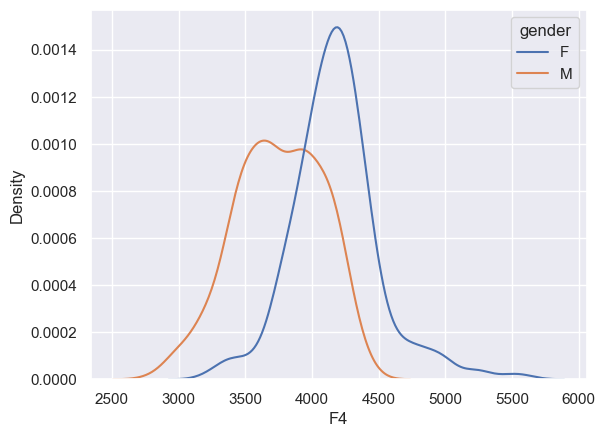

In [10]:
sns.kdeplot(all_data,x="F4",hue="gender",common_norm=False)

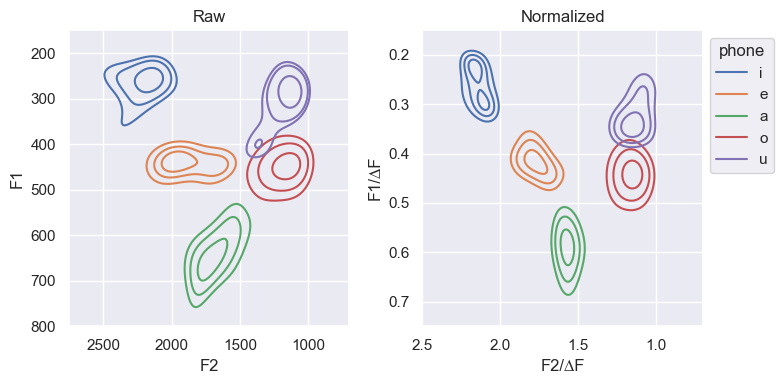

In [11]:

ho = ['i','e','a','o','u']
l = [0.75,0.85, 0.95]
xrange = [2.5,0.7]
yrange = [0.75,0.15]

fig1, axs = plt.subplots(ncols=2,figsize=(8,4))

sns.kdeplot(all_data,x="F2",y="F1",hue="phone",hue_order = ho,
            common_norm=False,levels=l,legend=False,ax=axs[0]).set(title="Raw")
axs[0].set_xlim((2750,700))
axs[0].set_ylim([800,150])

sns.kdeplot(all_data, x='F2/∆F',y='F1/∆F',hue="phone",hue_order= ho, 
            common_norm=False,levels=l,legend=True,ax=axs[1]).set(title="Normalized")
axs[1].set_xlim(xrange)
axs[1].set_ylim(yrange)
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
fig1.tight_layout()

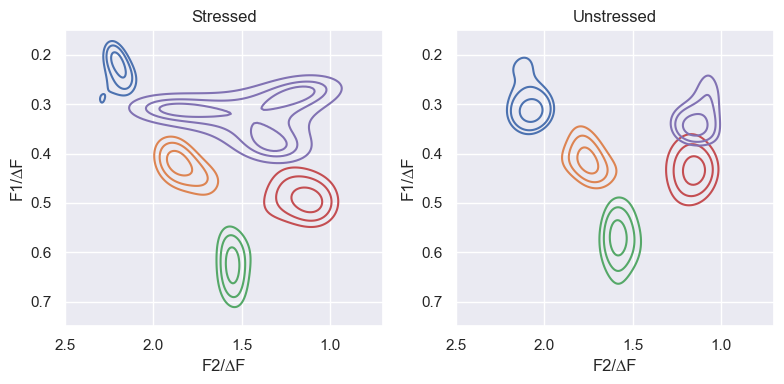

In [12]:
fig1, axs = plt.subplots(ncols=2,figsize=(8,4))


ho = ['i','e','a','o','u']


sns.kdeplot(all_data[all_data['stress'] == "stressed"],
            x='F2/∆F',y='F1/∆F',hue="phone",hue_order= ho, ax = axs[0],
            common_norm=False,levels=l,legend=False).set(title="Stressed")
sns.kdeplot(all_data[all_data['stress'] == "unstressed"],
            x='F2/∆F',y='F1/∆F',hue="phone",hue_order= ho, ax = axs[1],
            common_norm=False,levels=l,legend=False).set(title="Unstressed")
axs[0].set_xlim(xrange)
axs[0].set_ylim(yrange)
axs[1].set_xlim(xrange)
axs[1].set_ylim(yrange)
fig1.tight_layout()

In [13]:
pd.crosstab(all_data.stress,all_data.phone,margins=True)

phone,a,e,i,o,u,All
stress,,,,,,
stressed,58,45,23,33,3,162
unstressed,124,144,62,109,27,466
All,182,189,85,142,30,628
